# 1. Data loading

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

filename = 'NorthSeaData/FORCE_2020_train.csv' # nome do dado de entrada
df = pd.read_csv(filename) # leitura do dado de entrada

In [2]:
### number feature (well log profiling) visualization
df.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [3]:
# indata 
training_data = df[['WELL', 
                    'DEPTH_MD', 
                    'RMED', 
                    'RDEP', 
                    'RHOB', 
                    'GR', 
                    'NPHI',
                    'DTC', 
                    'PEF', 
                    'FORCE_2020_LITHOFACIES_LITHOLOGY']].copy()

In [4]:
# indata to use 
df = df[['WELL', 
         'DEPTH_MD', 
         'RMED', 
         'RDEP', 
         'RHOB', 
         'GR', 
         'NPHI',
         'DTC', 
         'PEF', 
         'FORCE_2020_LITHOFACIES_LITHOLOGY']].copy()

In [5]:
df.columns

Index(['WELL', 'DEPTH_MD', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC', 'PEF',
       'FORCE_2020_LITHOFACIES_LITHOLOGY'],
      dtype='object')

In [6]:
# List the number of wells
for well in df['WELL'].unique():
    
    print(well)

15/9-13
15/9-15
15/9-17
16/1-2
16/1-6 A
16/10-1
16/10-2
16/10-3
16/10-5
16/11-1 ST3
16/2-11 A
16/2-16


In [7]:
# List of headers
plot_cols = ['WELL', 'DEPTH_MD','RMED', 'RDEP', 'RHOB', 'GR', 'NPHI',
             'DTC', 'PEF','FORCE_2020_LITHOFACIES_LITHOLOGY']

In [8]:
df = df[plot_cols]

In [9]:
df.head()

,WELL,DEPTH_MD,RMED,RDEP,RHOB,GR,NPHI,DTC,PEF,FORCE_2020_LITHOFACIES_LITHOLOGY
0,15/9-13,494.528,1.611410,1.798681,1.884186,80.200851,NaN,161.131180,20.915468,65000
1,15/9-13,494.680,1.618070,1.795641,1.889794,79.262886,NaN,160.603470,19.383013,65000
2,15/9-13,494.832,1.626459,1.800733,1.896523,74.821999,NaN,160.173615,22.591518,65000
3,15/9-13,494.984,1.621594,1.801517,1.891913,72.878922,NaN,160.149429,32.191910,65000
4,15/9-13,495.136,1.602679,1.795299,1.880034,71.729141,NaN,160.128342,38.495632,65000


In [10]:
data_nan = df.copy()

In [11]:
for num, col in enumerate(data_nan.columns[2:]):
    data_nan[col] = data_nan[col].notnull() * (num + 1)
    data_nan[col].replace(0, num, inplace=True)
    print(col, num) #Print out the col name and number to verify it works

RMED 0
RDEP 1
RHOB 2
GR 3
NPHI 4
DTC 5
PEF 6
FORCE_2020_LITHOFACIES_LITHOLOGY 7


In [12]:
data_nan.describe()

,DEPTH_MD,RMED,RDEP,RHOB,GR,NPHI,DTC,PEF,FORCE_2020_LITHOFACIES_LITHOLOGY
count,133198.000000,133198.000000,133198.000000,133198.000000,133198.0,133198.000000,133198.000000,133198.000000,133198.0
mean,1792.944663,0.942627,1.944496,2.811221,4.0,4.688636,5.995773,6.757068,8.0
std,739.441515,0.232555,0.228962,0.391335,0.0,0.463053,0.064876,0.428856,0.0
min,415.261599,0.000000,1.000000,2.000000,4.0,4.000000,5.000000,6.000000,8.0
25%,1182.822400,1.000000,2.000000,3.000000,4.0,4.000000,6.000000,7.000000,8.0
50%,1747.524495,1.000000,2.000000,3.000000,4.0,5.000000,6.000000,7.000000,8.0
75%,2413.874901,1.000000,2.000000,3.000000,4.0,5.000000,6.000000,7.000000,8.0
max,3272.024000,1.000000,2.000000,3.000000,4.0,5.000000,6.000000,7.000000,8.0


# 2. Plotting the Data with and without NaN

In [13]:
grouped = data_nan.groupby('WELL')

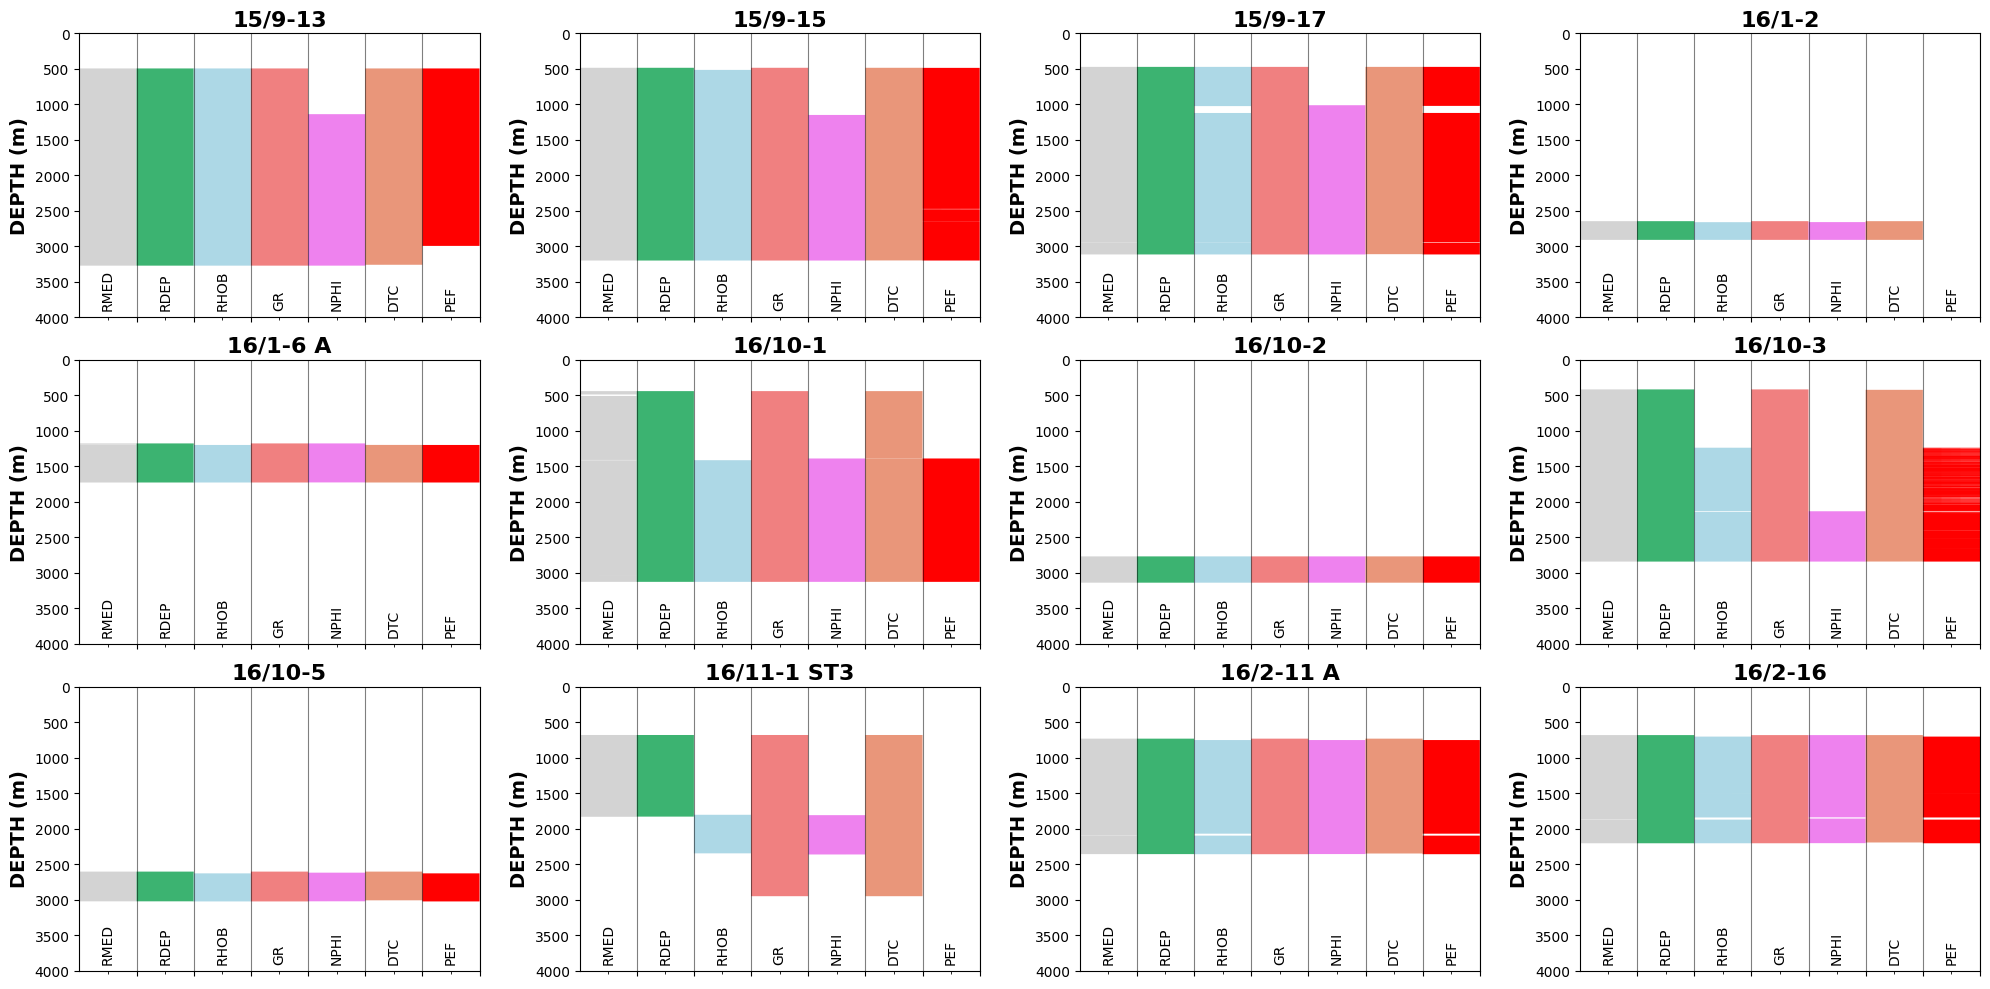

In [14]:
#Setup the labels we want to display on the x-axis
#labels = ['RMED','RDEP', 'RHOB','GR', 'NPHI', 'DTC'] # 6 features

#labels = ['CALI','RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP','DTS','DRHO', 'RMIC','RXO'] # 13 features
labels = ['RMED', 'RDEP', 'RHOB', 'GR', 'NPHI','DTC', 'PEF']


#Setup the figure and the subplots
fig, axs = plt.subplots(3, 4, figsize=(20,10))

#Loop through each well and column in the grouped dataframe
for (name, df), ax in zip(grouped, axs.flat):
    #ax.set_xlim(0,5) # 6 features
    ax.set_xlim(0,6) # 9 features
    
    #Setup the depth range
    ax.set_ylim(4000, 0)
    
    #Create multiple fill betweens for each curve# This is between
    # the number representing null values and the number representing
    # actual values
    
    #ax.fill_betweenx(df.DEPTH_MD, 0, df.CALI, facecolor='grey')
    ax.fill_betweenx(df.DEPTH_MD, 0, df.RMED, facecolor='lightgrey')
    ax.fill_betweenx(df.DEPTH_MD, 1, df.RDEP, facecolor='mediumseagreen')
    ax.fill_betweenx(df.DEPTH_MD, 2, df.RHOB, facecolor='lightblue')
    ax.fill_betweenx(df.DEPTH_MD, 3, df.GR, facecolor='lightcoral')
    ax.fill_betweenx(df.DEPTH_MD, 4, df.NPHI, facecolor='violet')
    ax.fill_betweenx(df.DEPTH_MD, 5, df.DTC, facecolor='darksalmon')
    ax.fill_betweenx(df.DEPTH_MD, 6, df.PEF, facecolor='red')
    #ax.fill_betweenx(df.DEPTH_MD, 6, df.SP, facecolor='thistle')
  
    
    #Setup the grid, axis labels and ticks
    ax.grid(axis='x', alpha=0.5, color='black')
    ax.set_ylabel('DEPTH (m)', fontsize=14, fontweight='bold')
    
    #Position vertical lines at the boundaries between the bars
    ax.set_xticks([1,2,3,4,5,6,7], minor=False)
    
    #Position the curve names in the centre of each column
    ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5], minor=True)
    
    #Setup the x-axis tick labels
    ax.set_xticklabels(labels,  rotation='vertical', minor=True, verticalalignment='bottom')
    ax.set_xticklabels('', minor=False)
    ax.tick_params(axis='x', which='minor', pad=-7)
    
    #Assign the well name as the title to each subplot
    ax.set_title(name, fontsize=16, fontweight='bold')

plt.savefig('missingdata_northsea.pdf')
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.25)
plt.show()

# 3. Select the headers to use in the in-data

In [15]:
training_data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'FACIES'}, inplace=True)

In [16]:
training_data

,WELL,DEPTH_MD,RMED,RDEP,RHOB,GR,NPHI,DTC,PEF,FACIES
0,15/9-13,494.528000,1.611410,1.798681,1.884186,80.200851,NaN,161.131180,20.915468,65000
1,15/9-13,494.680000,1.618070,1.795641,1.889794,79.262886,NaN,160.603470,19.383013,65000
2,15/9-13,494.832000,1.626459,1.800733,1.896523,74.821999,NaN,160.173615,22.591518,65000
3,15/9-13,494.984000,1.621594,1.801517,1.891913,72.878922,NaN,160.149429,32.191910,65000
4,15/9-13,495.136000,1.602679,1.795299,1.880034,71.729141,NaN,160.128342,38.495632,65000
...,...,...,...,...,...,...,...,...,...,...
133193,16/2-16,2207.310396,5.382444,5.339929,2.531374,127.456139,NaN,NaN,3.607062,30000
133194,16/2-16,2207.462396,5.651109,5.689734,2.526128,128.403305,NaN,NaN,3.609151,30000
133195,16/2-16,2207.614396,5.870602,5.496074,2.528934,127.829262,NaN,NaN,3.594580,30000
133196,16/2-16,2207.766396,5.756996,5.345353,2.527052,126.552277,NaN,NaN,3.534883,30000


# 4. Column Remapping / Renaming

In [17]:
lithology_numbers = {30000: 'Sandstone', # sandybrown
                     65030: 'Sandstone/Shale', #darkgoldenrod
                     65000: 'Shale', # olive
                     80000: 'Marl', #gainsboro
                     74000: 'Dolomite',
                     70000: 'Limestone',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Anhydrite',
                     99000: 'Tuff',
                     90000: 'Coal',
                     93000: 'Basement'}

second dictionary to tranform in integer

In [18]:
simple_lithology_numbers = {30000: 1,
                            65030: 2,
                            65000: 3,
                            80000: 4,
                            74000: 5,
                            70000: 6,
                            70032: 7,
                            88000: 8,
                            86000: 9,
                            99000: 10,
                            90000: 11,
                            93000: 12}

In [19]:
training_data['LITH'] = training_data['FACIES'].map(lithology_numbers)

In [20]:
training_data['LITH_SI'] = training_data['FACIES'].map(simple_lithology_numbers)

# 5. View the number of samples of the whole data

LITH_SI
1     15794
2      6573
3     82390
4      4968
5       188
6     11912
7      5129
8      4314
9       374
10     1498
11       58
Name: count, dtype: int64


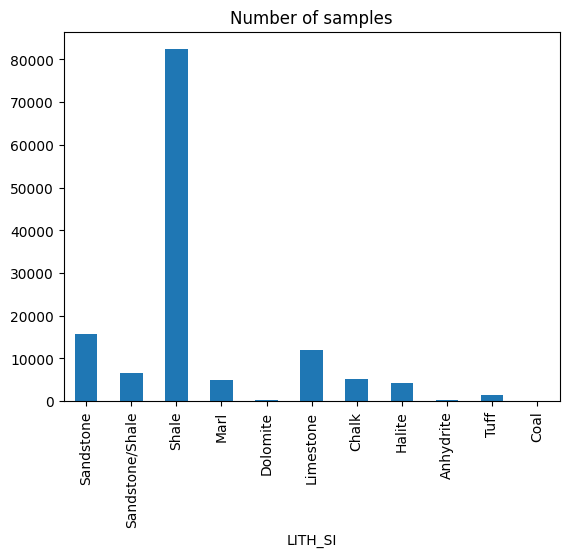

In [21]:
#plot the count of Facies
training_data['LITH_SI'].value_counts().sort_index().plot(kind='bar')
print(training_data['LITH_SI'].value_counts().sort_index())
X_ind = np.arange(0,11,1)
plt.title('Number of samples')
plt.xticks(X_ind,['Sandstone',
                  'Sandstone/Shale',
                  'Shale',
                  'Marl',
                  'Dolomite',
                  'Limestone',
                  'Chalk',
                  'Halite',
                  'Anhydrite',
                  'Tuff',
                  'Coal'])
plt.show()

# 6. Crossplot RHOB and NPHI (whole data)

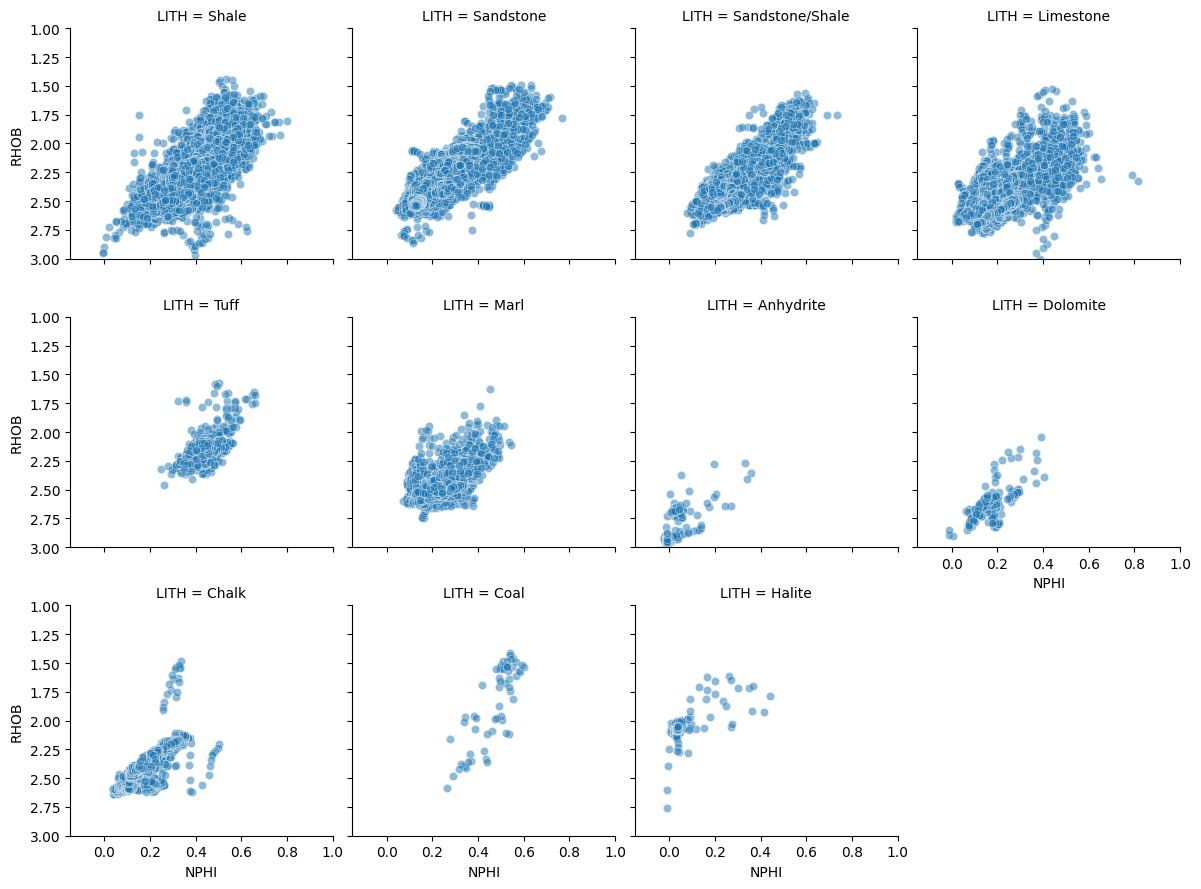

In [22]:
import seaborn as sns

g = sns.FacetGrid(training_data, col='LITH', col_wrap=4)
g.map(sns.scatterplot, 'NPHI', 'RHOB', alpha=0.5)
g.set(xlim=(-0.15, 1))
g.set(ylim=(3, 1))
plt.show()

In [23]:
# remove NaN
training_data.dropna(inplace=True)

In [24]:
for well in training_data['WELL'].unique():
    
    print(well)

15/9-13
15/9-15
15/9-17
16/1-6 A
16/10-1
16/10-2
16/10-3
16/10-5
16/2-11 A
16/2-16


# 7. sorting out the blind test well

In [25]:
blind = training_data[training_data['WELL'] == '16/2-16'] #seleciona um poço apenas do dado
training_data = training_data[training_data['WELL'] != '16/2-16'] #remove o poço do dado
blind

,WELL,DEPTH_MD,RMED,RDEP,RHOB,GR,NPHI,DTC,PEF,FACIES,LITH,LITH_SI
123313,16/2-16,705.550396,1.340541,1.364968,2.125565,122.600769,0.472988,157.843994,4.017347,65000,Shale,3
123314,16/2-16,705.702396,1.344673,1.366519,2.126764,126.172905,0.476745,157.064499,3.816923,65000,Shale,3
123315,16/2-16,705.854396,1.355193,1.377351,2.131069,131.125244,0.459273,156.237564,3.770154,65000,Shale,3
123316,16/2-16,706.006396,1.366960,1.377473,2.140570,129.771545,0.444680,155.374191,3.732529,65000,Shale,3
123317,16/2-16,706.158396,1.385934,1.404746,2.151072,123.866241,0.428803,154.711121,3.577061,65000,Shale,3
...,...,...,...,...,...,...,...,...,...,...,...,...
133119,16/2-16,2196.062396,5.016001,4.727455,2.537510,132.450317,0.112312,70.126060,3.663386,30000,Sandstone,1
133120,16/2-16,2196.214396,4.574865,4.421765,2.526997,131.869812,0.116130,70.316216,3.629687,30000,Sandstone,1
133121,16/2-16,2196.366396,4.761734,4.535498,2.520570,127.004021,0.120230,70.462158,3.615547,30000,Sandstone,1
133122,16/2-16,2196.518396,5.035505,4.870131,2.523459,124.698349,0.126182,70.337593,3.594654,30000,Sandstone,1


In [26]:
training_data['WELL'].unique()

array(['15/9-13', '15/9-15', '15/9-17', '16/1-6 A', '16/10-1', '16/10-2',
       '16/10-3', '16/10-5', '16/2-11 A'], dtype=object)

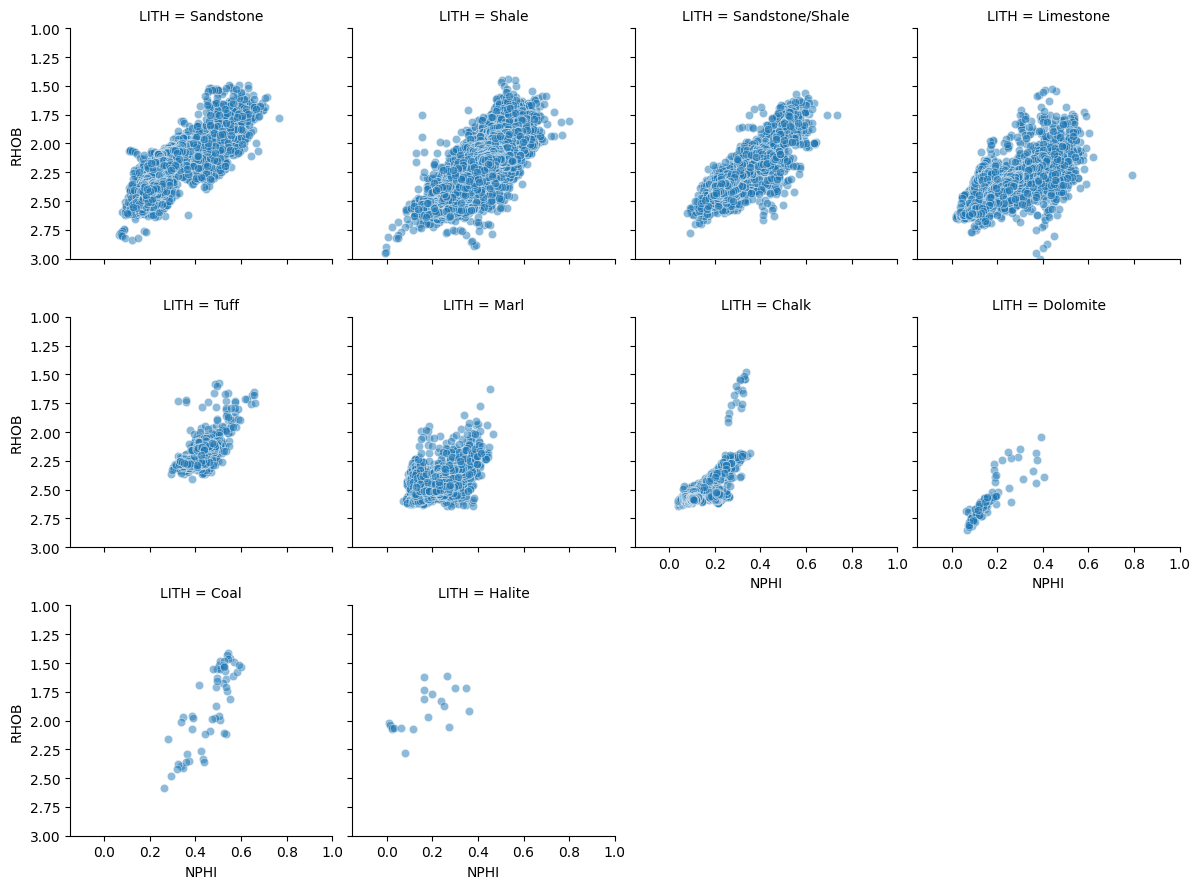

In [27]:
import seaborn as sns

g = sns.FacetGrid(training_data, col='LITH', col_wrap=4)
g.map(sns.scatterplot, 'NPHI', 'RHOB', alpha=0.5)
g.set(xlim=(-0.15, 1))
g.set(ylim=(3, 1))
plt.show()

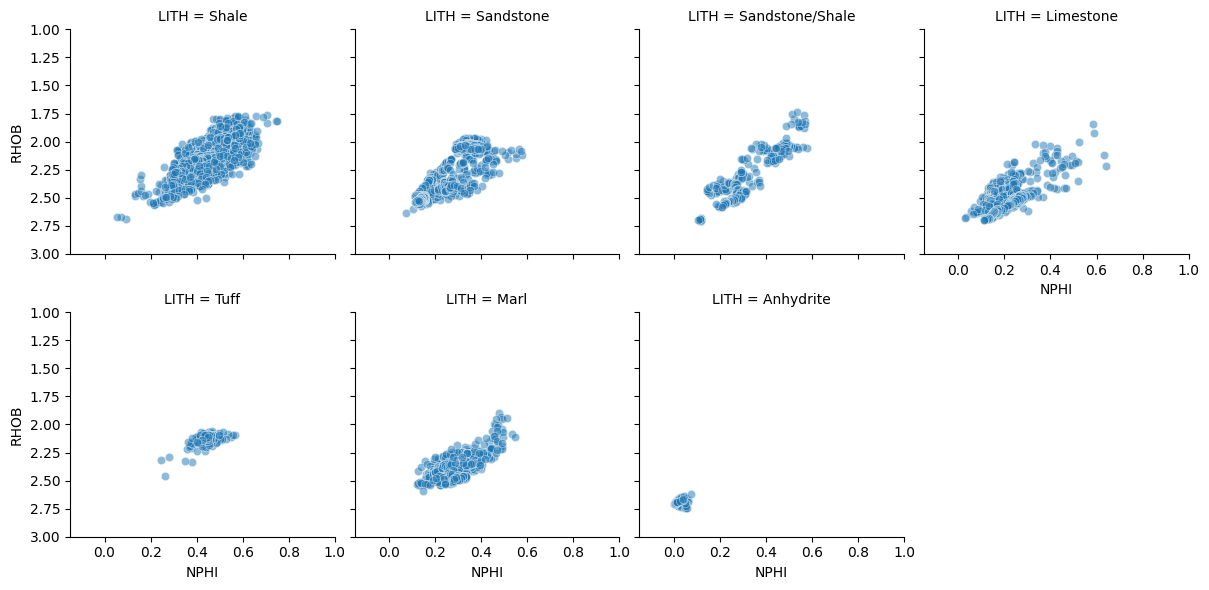

In [28]:
import seaborn as sns

g = sns.FacetGrid(blind, col='LITH', col_wrap=4)
g.map(sns.scatterplot, 'NPHI', 'RHOB', alpha=0.5)
g.set(xlim=(-0.15, 1))
g.set(ylim=(3, 1))
plt.show()

Two lithofacoes are exluded from data after dropping NaN.

LITH_SI
1     1237
2      264
3     5670
4      905
6     1277
9       75
10     168
Name: count, dtype: int64


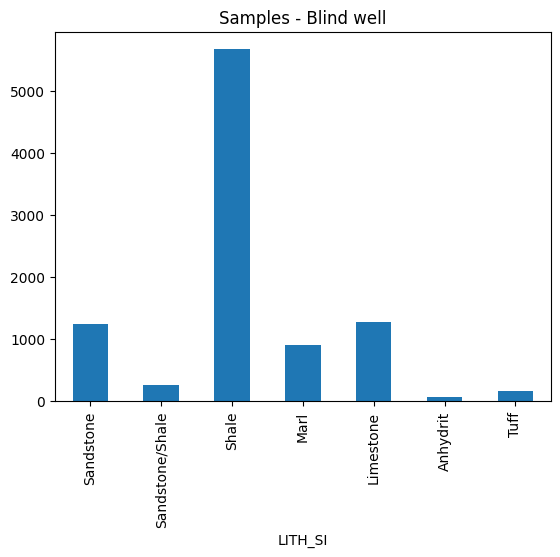

In [29]:
#plot the count of Facies
blind['LITH_SI'].value_counts().sort_index().plot(kind='bar')
print(blind['LITH_SI'].value_counts().sort_index())
X_ind = np.arange(0,7,1)
plt.title('Samples - Blind well')
plt.xticks(X_ind,['Sandstone',
                  'Sandstone/Shale',
                  'Shale',
                  'Marl',
                  'Limestone',
                  'Anhydrit',
                  'Tuff'])
plt.show()

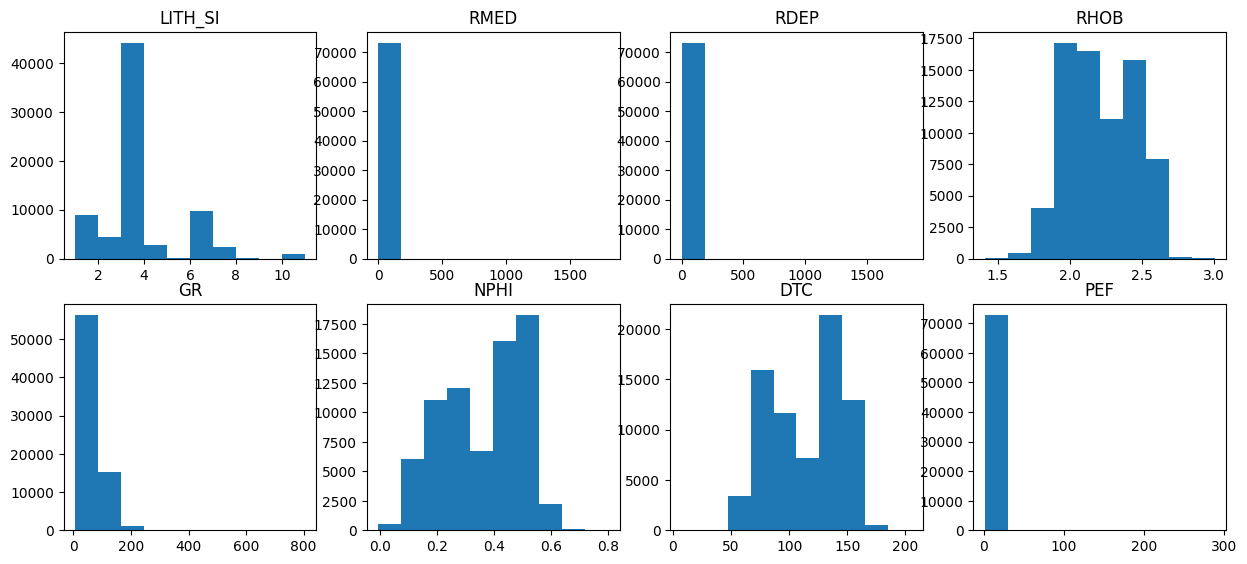

In [30]:
#['WELL', 'DEPTH_MD', 'RDEP', 'RHOB','GR', 'NPHI', 'PEF', 'DTC','SP']
#col_list = ['LITH_SI','RDEP', 'RHOB','GR', 'NPHI', 'PEF', 'DTC','SP']

col_list = ['LITH_SI','RMED', 'RDEP', 'RHOB', 'GR', 'NPHI','DTC', 'PEF']



plt.figure(figsize=(15,10))
i=0
for col in col_list:
    i+=1
    plt.subplot(3,4,i)
    plt.hist(training_data[col])
    plt.title(col)
plt.show()

LITH_SI
1      8837
2      4314
3     44151
4      2810
5        98
6      9714
7      2259
8        20
10      866
11       56
Name: count, dtype: int64


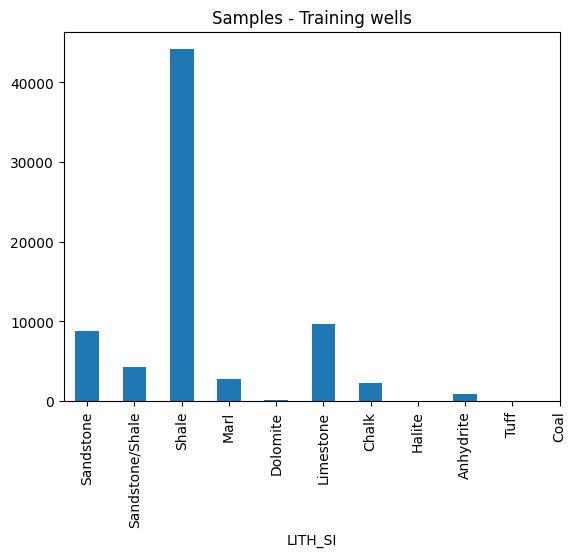

In [31]:
#plot the count of Facies
training_data['LITH_SI'].value_counts().sort_index().plot(kind='bar')
print(training_data['LITH_SI'].value_counts().sort_index())
X_ind = np.arange(0,11,1)
plt.title('Samples - Training wells')
plt.xticks(X_ind,['Sandstone',
                  'Sandstone/Shale',
                  'Shale',
                  'Marl',
                  'Dolomite',
                  'Limestone',
                  'Chalk',
                  'Halite',
                  'Anhydrite',
                  'Tuff',
                  'Coal'])
plt.show()

# 8. Prepare data for modeling and blind test well


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report

In [33]:
features = ['RMED', 'RDEP', 'RHOB', 'GR', 'NPHI','DTC', 'PEF']



y = training_data['LITH_SI']
X = training_data[features]

In [34]:
### Data for modelling

#scaler = StandardScaler().fit(X)
#X_stnd = scaler.transform(X)

# standarization of data for SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:
X.corr()

,RMED,RDEP,RHOB,GR,NPHI,DTC,PEF
RMED,1.000000,0.085010,0.093345,-0.063677,-0.134424,-0.120911,0.012963
RDEP,0.085010,1.000000,0.040408,-0.031926,-0.070180,-0.070503,0.046494
RHOB,0.093345,0.040408,1.000000,-0.128773,-0.857182,-0.859955,0.118039
GR,-0.063677,-0.031926,-0.128773,1.000000,0.384804,0.337936,-0.095782
NPHI,-0.134424,-0.070180,-0.857182,0.384804,1.000000,0.902656,-0.165047
DTC,-0.120911,-0.070503,-0.859955,0.337936,0.902656,1.000000,-0.203939
PEF,0.012963,0.046494,0.118039,-0.095782,-0.165047,-0.203939,1.000000


In [37]:
### Blind test well

y_blind = blind['LITH_SI']
X_blind = blind[features]
X_blind_stnd = sc.transform(X_blind)

In [38]:
#Plot loss and accuracy

import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mae']), label='Train')
    plt.plot(history.epoch, np.array(history.history['val_mae']),label = 'Val')
    plt.legend()
    plt.ylim([0,max(history.history['val_mae'])])

def plot_prediction(test_labels, test_predictions):
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [1000$]')
    plt.ylabel('Predictions [1000$]')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error [1000$]")
    _ = plt.ylabel("Count")

In [39]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    

    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 9. Parameter optimization and classifier training

In [40]:
# from sklearn.svm import SVC # To use Support Vector Machine
from sklearn import ensemble # To use Gradient Boosting and Random forest
# from sklearn.neighbors import KNeighborsClassifier # To use KNN
from sklearn.metrics import f1_score

In [41]:
training_features = ['Ss','Ss/Sh','Sh','M','D','L','Ch','H','T','C']
# list_blind_full =   ['Ss','Ss/Sh','Sh','M','L','Ch','A','T','C']
list_blind_full =   ['Ss','Ss/Sh','Sh','M','L','A','T']
# why do not fit and transform  GRADIENT BOOST
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.4, random_state=42)

### 9.5 CNN

In [42]:
import random
import numpy as np
import tensorflow as tf
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)
from tensorflow import keras
import pandas as pd


print(tf.__version__)

2.13.0


In [43]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [44]:
print(X_train.shape)
print(X_train[1].shape)
print(X_train[0])

(51187, 7)
(7,)
[-0.09681908 -0.04273459  1.18907202 -0.14358042 -0.92477089 -1.09868089
 -0.14137703]


In [45]:
sample_size = X_train.shape[0] # number of samples in train set
time_steps  = X_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("1 Sample shape:\n",train_data_reshaped[0].shape)
print("An example sample:\n", train_data_reshaped[0])

After reshape train data set shape:
 (51187, 7, 1)
1 Sample shape:
 (7, 1)
An example sample:
 [[-0.09681908]
 [-0.04273459]
 [ 1.18907202]
 [-0.14358042]
 [-0.92477089]
 [-1.09868089]
 [-0.14137703]]


In [46]:
test_data_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [47]:
test_data_reshaped.shape

(21938, 7, 1)

In [48]:
def build_conv1D_model():

    n_timesteps = train_data_reshaped.shape[1] #
    n_features  = train_data_reshaped.shape[2] # 
       
    
    model = keras.Sequential(name="model_conv1D")
    
    # 1st layer
    ks = 2
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=200, kernel_size=ks, strides=1, padding='valid', activation='relu', name="Conv1D_1"))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Conv1D(filters=200, kernel_size=ks, strides=1, padding='valid', activation='relu', name="Conv1D_2"))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Conv1D(filters=200, kernel_size=ks, strides=1, padding='valid', activation='relu', name="Conv1D_3"))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Conv1D(filters=200, kernel_size=ks, strides=1, padding='valid', activation='relu', name="Conv1D_4"))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    
    #model.add(keras.layers.MaxPooling1D(pool_size=1, name="MaxPooling1D_fisrt"))
    
    # Dense
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(12, activation='softmax'))


    optimizer_aux = tf.keras.optimizers.Adam()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer_aux ,metrics = ['accuracy'])
    
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()


Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 6, 200)            600       
                                                                 
 max_pooling1d (MaxPooling1  (None, 6, 200)            0         
 D)                                                              
                                                                 
 Conv1D_2 (Conv1D)           (None, 5, 200)            80200     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 200)            0         
 g1D)                                                            
                                                                 
 Conv1D_3 (Conv1D)           (None, 4, 200)            80200     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 200)           

In [49]:
earlystoping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                patience=5,
                                                verbose=1,
                                                mode='auto',
                                                restore_best_weights=True)
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      verbose=1,
                                                      save_best_only=True)

In [50]:
history_cnn = model_conv1D.fit(train_data_reshaped, y_train, validation_data = (test_data_reshaped,y_test),
                           batch_size = 512, 
                           callbacks = [model_checkpoint,earlystoping],
                           epochs = 1000,
                           verbose=1)

Epoch 1/1000
 98/100 [============================>.] - ETA: 0s - loss: 0.9365 - accuracy: 0.7288
Epoch 1: val_accuracy improved from -inf to 0.79410, saving model to weights.01-0.63.h5
100/100 [==============================] - 4s 30ms/step - loss: 0.9314 - accuracy: 0.7300 - val_loss: 0.6340 - val_accuracy: 0.7941
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.5995 - accuracy: 0.8007
Epoch 2: val_accuracy improved from 0.79410 to 0.81448, saving model to weights.02-0.56.h5
100/100 [==============================] - 3s 28ms/step - loss: 0.5995 - accuracy: 0.8008 - val_loss: 0.5564 - val_accuracy: 0.8145
Epoch 3/1000
100/100 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8177
Epoch 3: val_accuracy improved from 0.81448 to 0.82683, saving model to weights.03-0.52.h5
100/100 [==============================] - 3s 29ms/step - loss: 0.5366 - accuracy: 0.8177 - val_loss: 0.5217 - val_accuracy: 0.8268
Epoch 4/1000
100/100 [==================

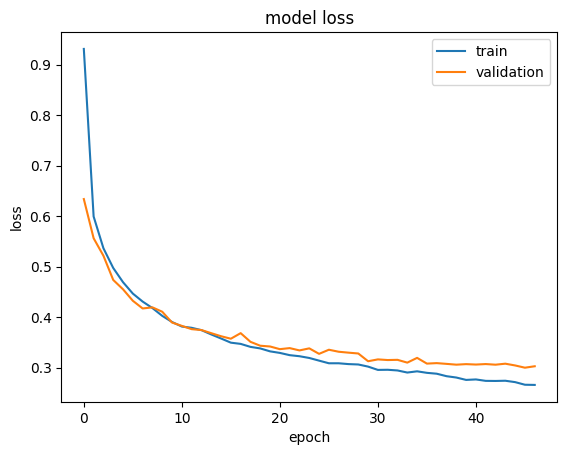

In [51]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])


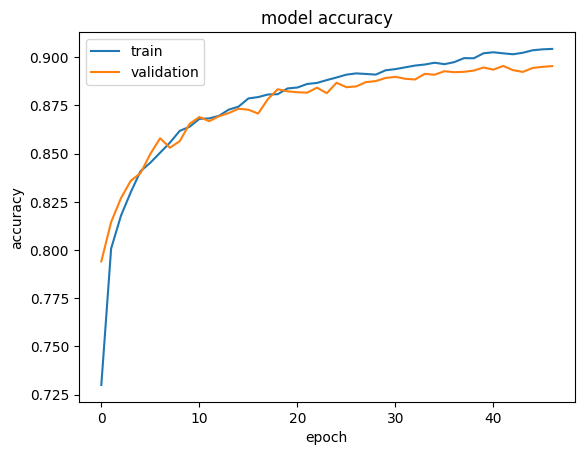

In [52]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.show()

In [53]:
pred_test_cnn = model_conv1D.predict(test_data_reshaped)

686/686 [==============================] - 1s 2ms/step


In [54]:
pred_test_cnn = tf.argmax(pred_test_cnn, axis=1)

In [55]:
test_loss, test_acc = model_conv1D.evaluate(test_data_reshaped,  y_test, verbose=2)

686/686 - 1s - loss: 0.3071 - accuracy: 0.8955 - 1s/epoch - 2ms/step


              precision    recall  f1-score   support

          Ss       0.83      0.88      0.86      2686
       Ss/Sh       0.71      0.56      0.62      1248
          Sh       0.94      0.97      0.95     13264
           M       0.82      0.71      0.76       873
           D       0.82      0.48      0.61        29
           L       0.87      0.85      0.86      2886
          Ch       0.78      0.76      0.77       654
           H       0.83      0.62      0.71         8
           T       0.67      0.50      0.57       272
           C       1.00      0.50      0.67        18

    accuracy                           0.90     21938
   macro avg       0.83      0.68      0.74     21938
weighted avg       0.89      0.90      0.89     21938

Normalized confusion matrix


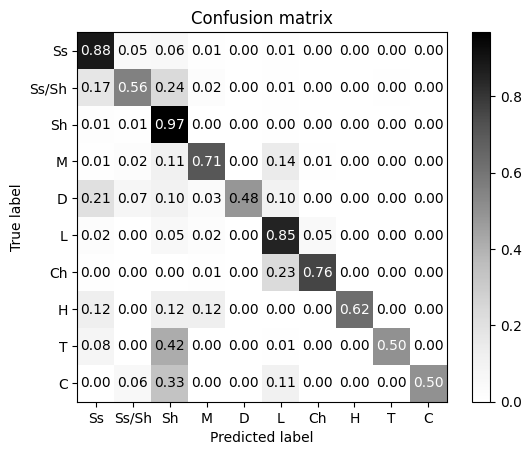

In [56]:
print(classification_report(y_test, pred_test_cnn, target_names=training_features))
cm_test_cnn = confusion_matrix(y_test, pred_test_cnn)
plot_confusion_matrix(cm_test_cnn, training_features, normalize=True)

In [57]:
microF1_test_cnn = f1_score(y_test, pred_test_cnn, average='micro')
print('Test Macro f1 score:', microF1_test_cnn)

Test Macro f1 score: 0.8954781657398122


In [58]:
X_blind_reshaped = X_blind_stnd.reshape(X_blind_stnd.shape[0],X_blind_stnd.shape[1],1)
X_blind_reshaped.shape

(9596, 7, 1)

In [59]:
aux = model_conv1D.predict(X_blind_reshaped)

  1/300 [..............................] - ETA: 5s

300/300 [==============================] - 0s 2ms/step


In [60]:
pred_blind_cnn = tf.argmax(aux, axis=1)

              precision    recall  f1-score   support

           1       0.77      0.51      0.62      1237
           2       0.18      0.25      0.21       264
           3       0.80      0.98      0.88      5670
           4       0.60      0.34      0.43       905
           5       0.00      0.00      0.00         0
           6       0.80      0.59      0.68      1277
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00        75
          10       0.25      0.01      0.02       168
          11       0.00      0.00      0.00         0

    accuracy                           0.76      9596
   macro avg       0.34      0.27      0.28      9596
weighted avg       0.75      0.76      0.74      9596

Normalized confusion matrix


c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\

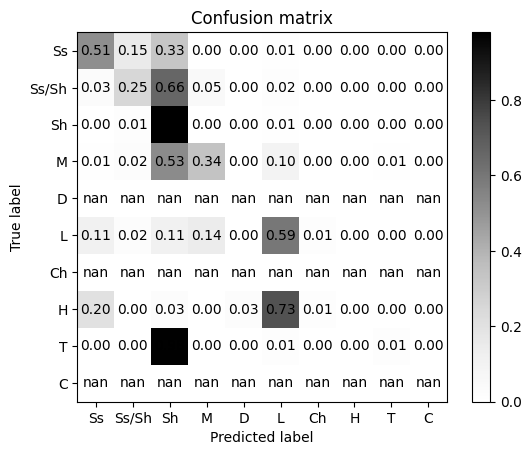

In [61]:
print(classification_report(y_blind, pred_blind_cnn))
cm_cnn = confusion_matrix(y_blind, pred_blind_cnn)
plot_confusion_matrix(cm_cnn, training_features, normalize=True)

In [62]:
microF1_blind_cnn = f1_score(y_blind, pred_blind_cnn, average='micro')
print('Test Macro f1 score:', microF1_blind_cnn)

Test Macro f1 score: 0.7633388912046687


### 9.6 CNN (RBF)

In [63]:
# import keras
# from keras.layers import Layer
# from keras import backend as K

# class RBFLayer(Layer):
#     def __init__(self, units, gamma, ** kwargs):
#         super(RBFLayer, self).__init__( ** kwargs)
#         self.units = units
#         self.gamma = K.cast_to_floatx(gamma)

#     def build(self, input_shape):
#         self.mu = self.add_weight(name = 'mu',
#                                   shape = (int(input_shape[1]), self.units),
#                                   initializer = 'uniform',
#                                   trainable = True)
#         super(RBFLayer, self).build(input_shape)

#     def call(self, inputs):
#         diff = K.expand_dims(inputs) - self.mu
#         l2 = K.sum(K.pow(diff, 2), axis = 1)
#         res = K.exp(-1 * self.gamma * l2)
#         return res
    
#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], self.units)
from rbflayer import RBFLayer, InitCentersRandom

In [64]:
def build_conv1D_rbf_model():
    #
    n_timesteps = train_data_reshaped.shape[1] #
    n_features  = train_data_reshaped.shape[2] # 
    #
    model_rbf = keras.Sequential(name="model_conv1D_rbf")
    # 1st layer
    ks = 2
    mp=1
    f=128
    model_rbf.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model_rbf.add(keras.layers.Conv1D(filters=f, kernel_size=ks, activation='relu', name="Conv1D_1"))
    model_rbf.add(keras.layers.Conv1D(filters=f, kernel_size=ks, activation='relu', name="Conv1D_2"))
    model_rbf.add(keras.layers.MaxPooling1D(pool_size=mp))
    model_rbf.add(keras.layers.Dropout(0.2))
    model_rbf.add(keras.layers.BatchNormalization())
    # # 2nd layer
    model_rbf.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model_rbf.add(keras.layers.Conv1D(filters=f, kernel_size=ks, activation='relu', name="Conv1D_3"))
    model_rbf.add(keras.layers.Conv1D(filters=f, kernel_size=ks, activation='relu', name="Conv1D_4"))
    model_rbf.add(keras.layers.MaxPooling1D(pool_size=mp))
    model_rbf.add(keras.layers.Dropout(0.2))
    model_rbf.add(keras.layers.BatchNormalization())
    # # 3rd layer
    model_rbf.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model_rbf.add(keras.layers.Conv1D(filters=f, kernel_size=ks, activation='relu', name="Conv1D_5"))
    model_rbf.add(keras.layers.Conv1D(filters=f, kernel_size=ks, activation='relu', name="Conv1D_6"))
    model_rbf.add(keras.layers.MaxPooling1D(pool_size=mp))
    model_rbf.add(keras.layers.Dropout(0.2))
    model_rbf.add(keras.layers.BatchNormalization())
    rbflayer = RBFLayer(f,betas=2.0,input_shape=(1,))
    model_rbf.add(rbflayer)
    # Dense
    model_rbf.add(keras.layers.Flatten())
    model_rbf.add(keras.layers.Dense(512, activation='relu'))
    model_rbf.add(keras.layers.Dropout(0.2))
    model_rbf.add(keras.layers.Dense(12, activation='softmax'))


    optimizer_aux = tf.keras.optimizers.Adam()
    model_rbf.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer_aux ,metrics = ['accuracy'])
    
    return model_rbf

model_conv1D_rbf = build_conv1D_rbf_model()
model_conv1D_rbf.summary()


Model: "model_conv1D_rbf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 6, 128)            384       
                                                                 
 Conv1D_2 (Conv1D)           (None, 5, 128)            32896     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 batch_normalization (Batch  (None, 5, 128)            512       
 Normalization)                                                  
                                                                 
 input_3 (InputLayer)        multiple             

In [65]:
history_rbf = model_conv1D_rbf.fit(train_data_reshaped, y_train, validation_data = (test_data_reshaped,y_test),
                           batch_size = 512, 
                           callbacks = [model_checkpoint,earlystoping],
                           epochs = 1000,
                           verbose=1)
# history_rbf = model_conv1D_rbf.fit(
#     train_data_reshaped, 
#     y_train, 
#     epochs = 1000,
#     steps_per_epoch=len(train_data_reshaped)/10,
#     validation_data = (test_data_reshaped,y_test),
#     validation_steps= len(test_data_reshaped),
#     batch_size = 512, 
#     callbacks = [model_checkpoint,earlystoping], 
    
#     verbose=1)

Epoch 1/1000
 98/100 [============================>.] - ETA: 0s - loss: 0.8185 - accuracy: 0.7492
Epoch 1: val_accuracy did not improve from 0.89548
100/100 [==============================] - 5s 29ms/step - loss: 0.8147 - accuracy: 0.7502 - val_loss: 1.0969 - val_accuracy: 0.6132
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.5644 - accuracy: 0.8133
Epoch 2: val_accuracy did not improve from 0.89548
100/100 [==============================] - 3s 27ms/step - loss: 0.5645 - accuracy: 0.8132 - val_loss: 1.1585 - val_accuracy: 0.6314
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.8271
Epoch 3: val_accuracy did not improve from 0.89548
100/100 [==============================] - 3s 28ms/step - loss: 0.5148 - accuracy: 0.8271 - val_loss: 1.0642 - val_accuracy: 0.6813
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.4879 - accuracy: 0.8339
Epoch 4: val_accuracy did not improve from 0.89548
100/100 

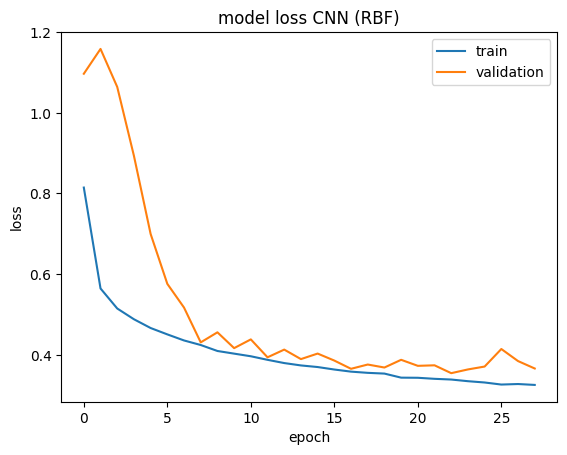

In [66]:
plt.plot(history_rbf.history['loss'])
plt.plot(history_rbf.history['val_loss'])
plt.title('model loss CNN (RBF)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])


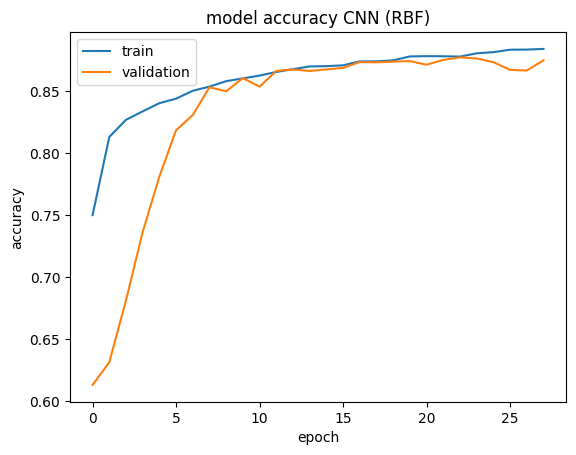

In [67]:
plt.plot(history_rbf.history['accuracy'])
plt.plot(history_rbf.history['val_accuracy'])
plt.title('model accuracy CNN (RBF)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.show()

In [68]:
pred_test_rbf = model_conv1D_rbf.predict(test_data_reshaped)

686/686 [==============================] - 1s 1ms/step


In [69]:
pred_test_rbf = tf.argmax(pred_test_rbf, axis=1)

              precision    recall  f1-score   support

           1       0.85      0.84      0.85      2686
           2       0.61      0.61      0.61      1248
           3       0.94      0.96      0.95     13264
           4       0.74      0.70      0.72       873
           5       1.00      0.31      0.47        29
           6       0.81      0.85      0.83      2886
           7       0.75      0.45      0.56       654
           8       0.86      0.75      0.80         8
          10       0.59      0.54      0.57       272
          11       1.00      0.50      0.67        18

    accuracy                           0.88     21938
   macro avg       0.82      0.65      0.70     21938
weighted avg       0.88      0.88      0.87     21938

Normalized confusion matrix


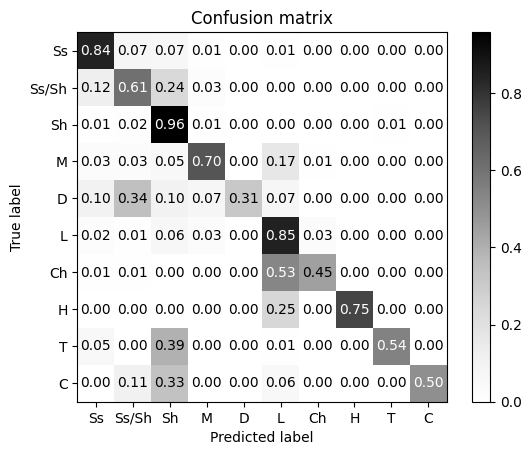

In [70]:
print(classification_report(y_test, pred_test_rbf))
cm_test_rbf = confusion_matrix(y_test, pred_test_rbf)
plot_confusion_matrix(cm_test_rbf, training_features, normalize=True)

In [71]:
microF1_test_rbf = f1_score(y_test, pred_test_rbf, average='micro')
print('Test Macro f1 score:', microF1_test_rbf)

Test Macro f1 score: 0.8774728781110402


In [72]:
pred_blind_rbf = model_conv1D_rbf.predict(X_blind_reshaped)

300/300 [==============================] - 0s 1ms/step


In [73]:
pred_blind_rbf = tf.argmax(pred_blind_rbf, axis=1)

              precision    recall  f1-score   support

           1       0.75      0.48      0.58      1237
           2       0.16      0.37      0.23       264
           3       0.83      0.99      0.90      5670
           4       0.56      0.38      0.46       905
           5       0.00      0.00      0.00         0
           6       0.90      0.57      0.70      1277
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00        75
          10       0.64      0.04      0.08       168
          11       0.00      0.00      0.00         0

    accuracy                           0.77      9596
   macro avg       0.38      0.28      0.29      9596
weighted avg       0.77      0.77      0.75      9596

Normalized confusion matrix


c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\

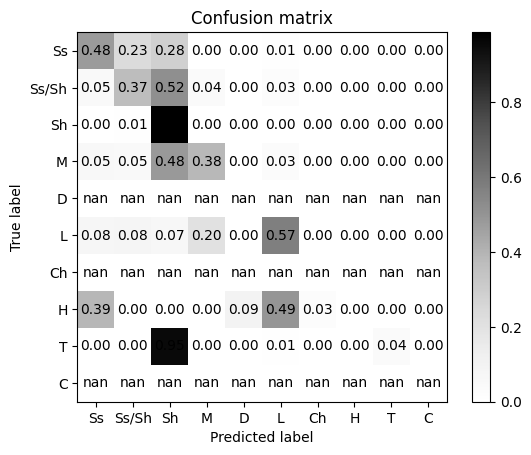

In [74]:
# list_blind = ['Ss',
#               'Ss/Sh',
#               'Sh',
#               'M',
#               'L',
#               'T']

print(classification_report(y_blind, pred_blind_rbf))
cm_rbf = confusion_matrix(y_blind, pred_blind_rbf)
plot_confusion_matrix(cm_rbf, training_features, normalize=True)

# 10. Model performance evaluation

I will use the diagnosis of confusion matrix from train data set to evaluate the model performance. The diagnosis of confusion matrix points how much percentage of the stone is correctly predicted.

In [75]:
### To create a data frame recording the correct prediction (normalized) of 
### facies for each machine learning algorithm

mod_test_list = ['CNN','CNN-RBF']
cm_test_list = [cm_test_cnn, cm_test_rbf]
face_test_list = training_features
pred_test_df = pd.DataFrame(index=training_features, columns=mod_test_list)

for mod in mod_test_list:
    
    col_index = int(mod_test_list.index(mod))
    cm = cm_test_list[col_index]
    
    for face in face_test_list:
        row_index = training_features.index(face)
        #print(face, row_index, col_index)
        pred_test_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])
        

### add the accuracy factor
df_1 = pd.DataFrame([[microF1_test_cnn, 
                      microF1_test_rbf]], index=['Accuracy'], columns=mod_test_list)    


pred_test_conc = pd.concat([pred_test_df,df_1])
pred_test_conc

,CNN,CNN-RBF
Ss,0.883842,0.844378
Ss/Sh,0.55609,0.606571
Sh,0.968562,0.957479
M,0.705613,0.703322
D,0.482759,0.310345
L,0.849965,0.847886
Ch,0.759939,0.446483
H,0.625,0.75
T,0.5,0.544118
C,0.5,0.5


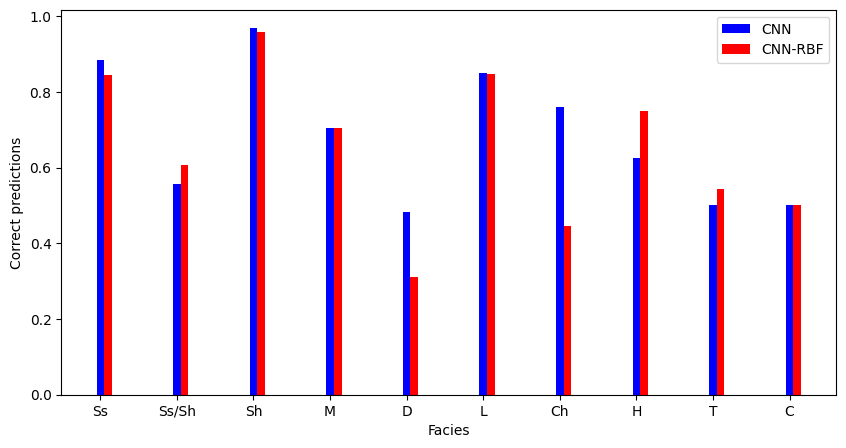

In [76]:
X_ind = np.arange(pred_test_df.shape[0])
(pred_df_index_list) = training_features
aux=0.1
plt.figure(figsize=(10,5))
plt.bar(X_ind, pred_test_df['CNN'], color='blue', width=aux)
plt.bar(X_ind+0.1, pred_test_df['CNN-RBF'], color='red', width=aux)

plt.xticks(X_ind, pred_df_index_list)
plt.xlabel('Facies')
plt.ylabel('Correct predictions')
plt.legend(labels=mod_test_list)
plt.savefig('canada_performance_evaluation_test_data.pdf',bbox_inches='tight')
plt.show()

# 11. Calssifier evluation using blind test well

I will use the same method shown in item4 for evaluation.

In [77]:
### To create a data frame recording the correct prediction (normalized) of facies of blind test well for each machine learning algorithm

blind_class  = ['Sandstone',
                  'Sandstone/Shale',
                  'Shale',
                  'Marl',
                  'Limestone',
                  'Chalk',
                  'Anhydrite',
                  'Tuff']

mod_list = ['CNN','CNN-RBF']
cm_list = [cm_cnn, cm_rbf]
pred_df = pd.DataFrame(index=list_blind_full, columns=mod_list)

for mod in mod_list:
    col_index = int(mod_list.index(mod))
    cm = cm_list[col_index]
    
    for face in list_blind_full:
        
        row_index = list_blind_full.index(face)
        #print(face, row_index, col_index)
        pred_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])



C:\Users\CometLake_05\AppData\Local\Temp\ipykernel_11688\2016940956.py:24: RuntimeWarning: invalid value encountered in scalar divide
  pred_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])


In [78]:
blind

,WELL,DEPTH_MD,RMED,RDEP,RHOB,GR,NPHI,DTC,PEF,FACIES,LITH,LITH_SI
123313,16/2-16,705.550396,1.340541,1.364968,2.125565,122.600769,0.472988,157.843994,4.017347,65000,Shale,3
123314,16/2-16,705.702396,1.344673,1.366519,2.126764,126.172905,0.476745,157.064499,3.816923,65000,Shale,3
123315,16/2-16,705.854396,1.355193,1.377351,2.131069,131.125244,0.459273,156.237564,3.770154,65000,Shale,3
123316,16/2-16,706.006396,1.366960,1.377473,2.140570,129.771545,0.444680,155.374191,3.732529,65000,Shale,3
123317,16/2-16,706.158396,1.385934,1.404746,2.151072,123.866241,0.428803,154.711121,3.577061,65000,Shale,3
...,...,...,...,...,...,...,...,...,...,...,...,...
133119,16/2-16,2196.062396,5.016001,4.727455,2.537510,132.450317,0.112312,70.126060,3.663386,30000,Sandstone,1
133120,16/2-16,2196.214396,4.574865,4.421765,2.526997,131.869812,0.116130,70.316216,3.629687,30000,Sandstone,1
133121,16/2-16,2196.366396,4.761734,4.535498,2.520570,127.004021,0.120230,70.462158,3.615547,30000,Sandstone,1
133122,16/2-16,2196.518396,5.035505,4.870131,2.523459,124.698349,0.126182,70.337593,3.594654,30000,Sandstone,1


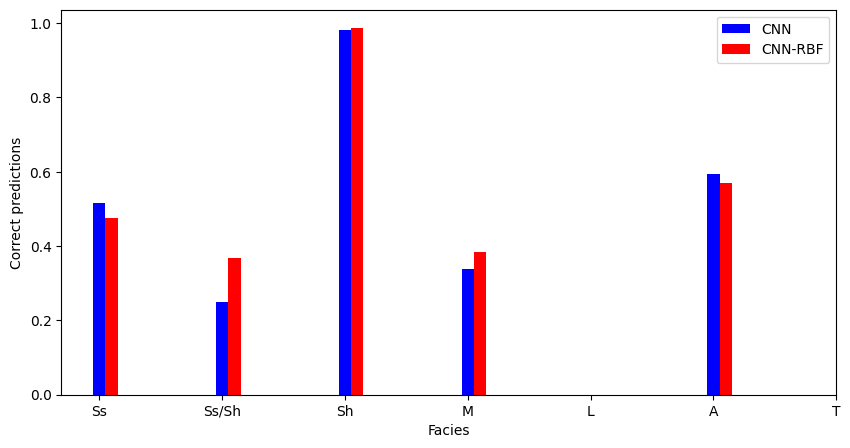

In [79]:
X_ind = np.arange(pred_df.shape[0])

aux=0.1
plt.figure(figsize=(10,5))
plt.bar(X_ind, pred_df['CNN'], color='blue', width=aux)
plt.bar(X_ind+0.1, pred_df['CNN-RBF'], color='red', width=aux)
plt.xticks(X_ind, list_blind_full)
plt.xlabel('Facies')
plt.ylabel('Correct predictions')
plt.legend(labels=mod_list)
plt.savefig('canada_performance_evaluation_blind_data.pdf',bbox_inches='tight')
plt.show()

# 12. Plot the predicted facies for comparison**

In [80]:
blind = blind.copy()
blind['CNN'] = pred_blind_cnn
blind['RBF'] = pred_blind_rbf


blind.head()

,WELL,DEPTH_MD,RMED,RDEP,RHOB,GR,NPHI,DTC,PEF,FACIES,LITH,LITH_SI,CNN,RBF
123313,16/2-16,705.550396,1.340541,1.364968,2.125565,122.600769,0.472988,157.843994,4.017347,65000,Shale,3,3,3
123314,16/2-16,705.702396,1.344673,1.366519,2.126764,126.172905,0.476745,157.064499,3.816923,65000,Shale,3,3,3
123315,16/2-16,705.854396,1.355193,1.377351,2.131069,131.125244,0.459273,156.237564,3.770154,65000,Shale,3,3,3
123316,16/2-16,706.006396,1.366960,1.377473,2.140570,129.771545,0.444680,155.374191,3.732529,65000,Shale,3,3,3
123317,16/2-16,706.158396,1.385934,1.404746,2.151072,123.866241,0.428803,154.711121,3.577061,65000,Shale,3,3,3


In [81]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

facies_colors = ['bisque',
                 'darkorange',
                 'darkgoldenrod',
                 'peachpuff',
                 'beige',
                 'white',
                 'red']

blind_class  = ['Ss',
                  'Ss/Sh',
                  'Sh',
                  'M',
                  'L',
                  'A',
                  'T']

def compare_facies_plot(logs, compare1, compare2, facies_colors):
      #make sure logs are sorted by depth
    logs = logs.sort_values(by='DEPTH_MD')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    num_colors = 7
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    
    cluster0 = np.repeat(np.expand_dims(logs['LITH_SI'].values,1), 100, 1)
    cluster1 = np.repeat(np.expand_dims(logs[compare1].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compare2].values,1), 100, 1)
    # cluster3 = np.repeat(np.expand_dims(logs[compare3].values,1), 100, 1)
    # cluster4 = np.repeat(np.expand_dims(logs[compare4].values,1), 100, 1)
    # cluster5 = np.repeat(np.expand_dims(logs[compare5].values,1), 100, 1)
    # cluster6 = np.repeat(np.expand_dims(logs[compare6].values,1), 100, 1)
    # cluster7 = np.repeat(np.expand_dims(logs[compare7].values,1), 100, 1)
    
    
    f, ax = plt.subplots(nrows=1, ncols=10, figsize=(18, 15))
    ax[0].plot(logs.RMED, logs.DEPTH_MD, '-',color='red')
    ax[1].plot(logs.RDEP, logs.DEPTH_MD, '-',color='blue')
    ax[2].plot(logs.RHOB, logs.DEPTH_MD, '-', color='red')
    ax[3].plot(logs.GR, logs.DEPTH_MD, '-', color='green')
    ax[4].plot(logs.NPHI, logs.DEPTH_MD, '--', color='blue')
    ax[5].plot(logs.DTC, logs.DEPTH_MD, '-', color='black')
    ax[6].plot(logs.PEF, logs.DEPTH_MD, '-', color='black')
    im0 = ax[7].imshow(cluster0, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=num_colors)
    im1 = ax[8].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=num_colors)
    im2 = ax[9].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=num_colors)
    # im3 = ax[10].imshow(cluster3, interpolation='none', aspect='auto',
    #                 cmap=cmap_facies,vmin=1,vmax=num_colors)
    # im4 = ax[11].imshow(cluster4, interpolation='none', aspect='auto',
    #                 cmap=cmap_facies,vmin=1,vmax=num_colors)
    # im4 = ax[12].imshow(cluster5, interpolation='none', aspect='auto',
    #                 cmap=cmap_facies,vmin=1,vmax=num_colors)
    # im4 = ax[13].imshow(cluster6, interpolation='none', aspect='auto',
    #                 cmap=cmap_facies,vmin=1,vmax=num_colors)
    # im4 = ax[14].imshow(cluster7, interpolation='none', aspect='auto',
    #                 cmap=cmap_facies,vmin=1,vmax=num_colors)
    
            
    divider = make_axes_locatable(ax[9])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((30*' ').join(blind_class))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-3):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=4)
    
    ax[0].set_xlabel("RMED")
    ax[0].set_xlim(0.2,5)
    
    ax[1].set_xlabel("RDEP")
    ax[1].set_xlim(0.2,5)
    
    ax[2].set_xlabel("RHOB")
    ax[2].set_xlim(1.95,2.95)
    
    ax[3].set_xlabel("GR")
    ax[3].set_xlim(0,150)
    
    ax[4].set_xlabel("NPHI")
    ax[4].set_xlim(0.45,-0.15)
    
    ax[5].set_xlabel("DTC")
    ax[5].set_xlim(logs.DTC.min(),logs.DTC.max())
    
    ax[6].set_xlabel("PEF")
    ax[6].set_xlim(logs.PEF.min(),logs.PEF.max())
    
    ax[7].set_xlabel('Facies')
    ax[8].set_xlabel(compare1)
    ax[9].set_xlabel(compare2)
    # ax[10].set_xlabel(compare3)
    # ax[11].set_xlabel(compare4)
    # ax[12].set_xlabel(compare5)
    # ax[13].set_xlabel(compare6)
    # ax[14].set_xlabel(compare7)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[7].set_yticklabels([]); ax[8].set_yticklabels([]); ax[9].set_yticklabels([])
    # ax[10].set_yticklabels([]); ax[11].set_yticklabels([]); ax[12].set_yticklabels([])
    # ax[13].set_yticklabels([]); ax[14].set_yticklabels([])
    
    
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    ax[8].set_xticklabels([])
    ax[9].set_xticklabels([])
    # ax[10].set_xticklabels([])
    # ax[11].set_xticklabels([])
    # ax[12].set_xticklabels([])
    # ax[13].set_xticklabels([])
    # ax[14].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['WELL'], fontsize=14,y=0.94)

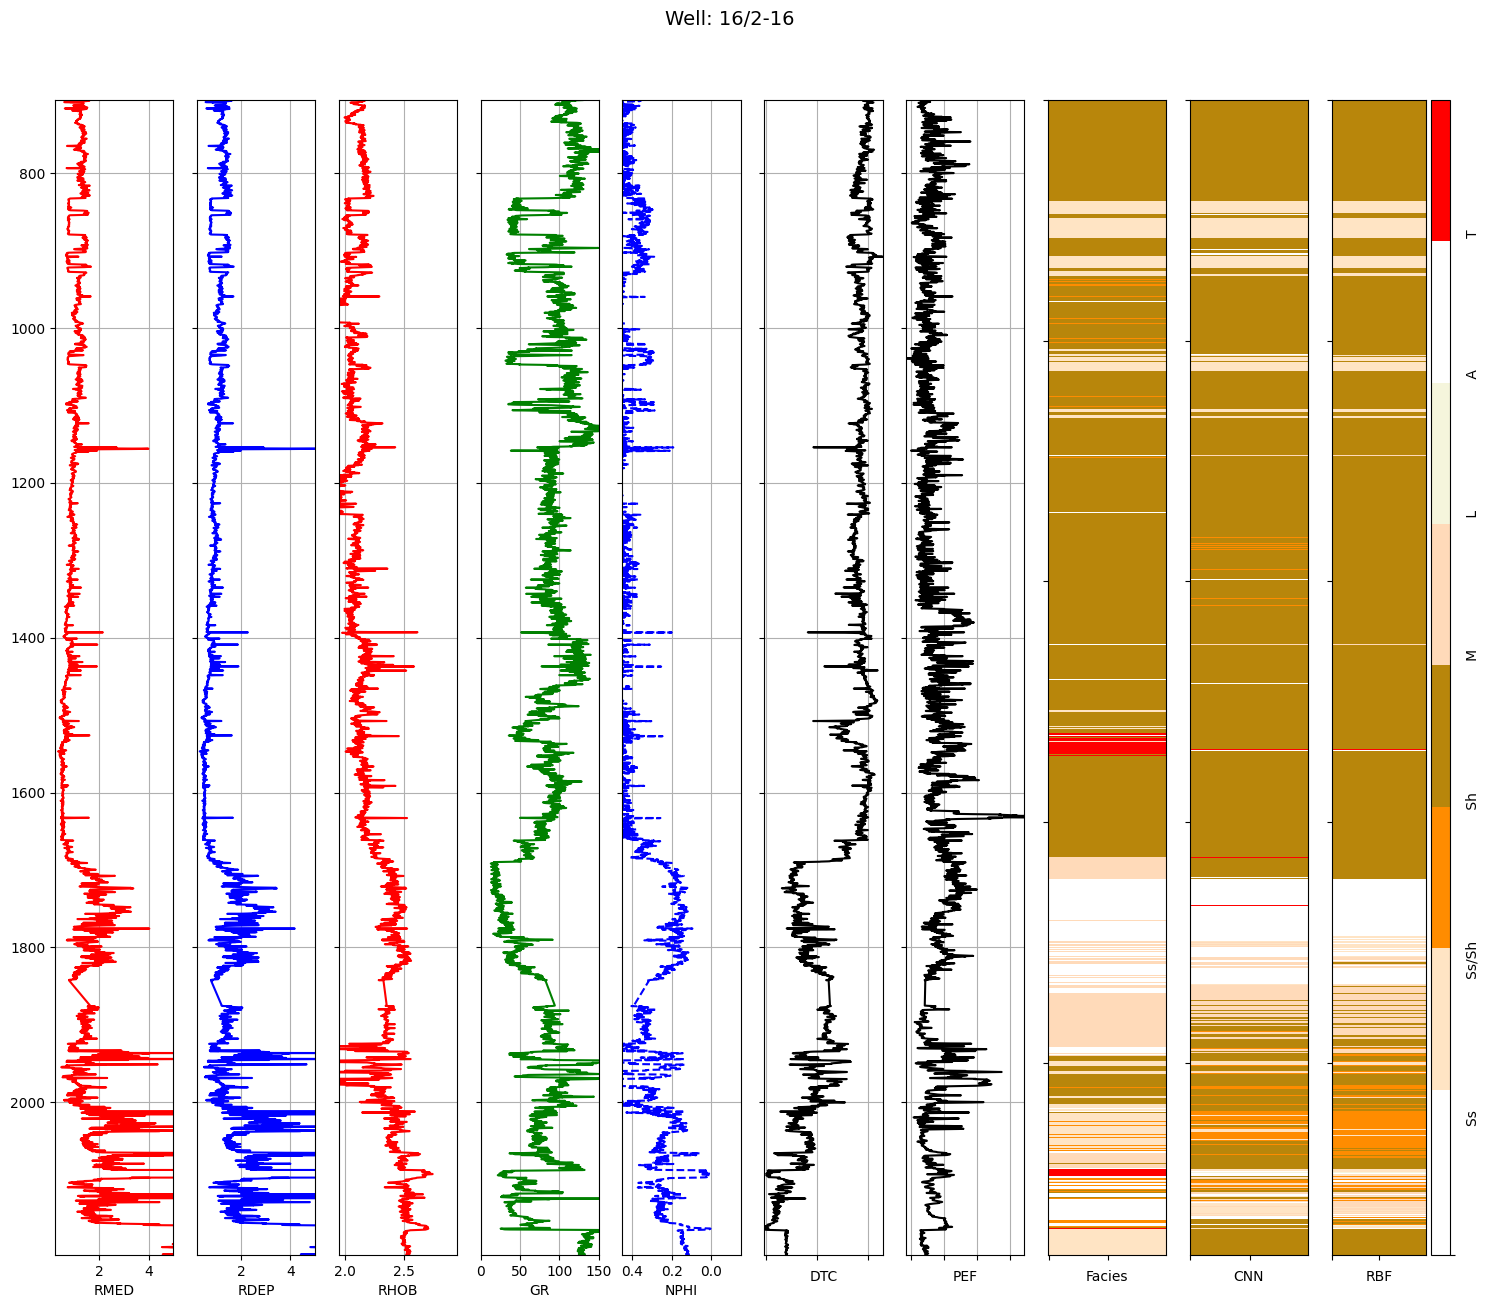

In [82]:
compare_facies_plot(blind, 'CNN','RBF', facies_colors)